# Tehnici de segmentare

Segmentarea imaginilor reprezintă procesul de împărțire a pixelilor unei imagini în diferite clase (de regulă foreground/background). În cazul în care imaginea este o imagine cu tonuri de gri, separarea pixelilor în foreground/background implică separarea intensității acestora în două grupe. Procesul este, în esență, un proces de clusterizare/partiționare.

In [ ]:
import cv2
from google.colab import files
import numpy as np
from google.colab.patches import cv2_imshow
import ipywidgets as widgets
from skimage import segmentation, color
from skimage.segmentation import quickshift

# Functii

## K-means

In [ ]:
def perform_kmeans_segmentation(image, k=5):
    # Flatten the image into a 1D array of pixel intensities
    pixel_values = image.reshape((-1, 1)).astype(np.float32)

    # Define criteria for K-means (stop after 100 iterations or when epsilon is 0.2)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    # Apply K-means clustering
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert the centers to uint8 (pixel intensity values)
    centers = np.uint8(centers)

    # Map each pixel to its corresponding cluster center
    segmented_image = centers[labels.flatten()]

    # Reshape the segmented image back to the original image dimensions
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

## MeanShift

In [ ]:
def perform_mean_shift_segmentation(image, spatial_radius=10, color_radius=20):
    # Convert the image to color if it's grayscale (Mean-Shift works on color images)
    print(spatial_radius)
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Apply Mean-Shift filtering
    segmented_image = cv2.pyrMeanShiftFiltering(image, spatial_radius, color_radius)

    return segmented_image

## Otsu

In [ ]:
def otsu_segmentation(image):
    # Convert to grayscale

    # Apply Otsu's thresholding
    _, otsu_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    return otsu_img

## Variance segmentation

### Extract blocks

In [ ]:
def extract_high_variance_blocks(image, n, variance_threshold):
    height, width = image.shape

    num_blocks_y = height // n
    num_blocks_x = width // n

    # List to store variances of all blocks
    variances = []

    # Iterate over blocks to calculate variances
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Extract the block
            y_start = i * n
            y_end = (i + 1) * n
            x_start = j * n
            x_end = (j + 1) * n
            block = image[y_start:y_end, x_start:x_end]

            # Calculate the variance of the block
            block_variance = np.var(block)
            variances.append((block_variance, (y_start, y_end, x_start, x_end, block)))

    # Calculate the mean and max variance of the image
    max_variance = max([v[0] for v in variances])
    min_variance = min([v[0] for v in variances])
    mean_variance = np.mean([v[0] for v in variances])

    if max_variance == mean_variance:
        print("All blocks have the same variance. Returning an empty list.")
        return []

    # Extract blocks with variance differing by the threshold and calculate gray values
    high_variance_blocks = []
    for block_variance, (y_start, y_end, x_start, x_end, block) in variances:
        variance_diff = block_variance - min_variance
        if variance_diff > variance_threshold:
            # Calculate the gray value for the block
            gray_value = int(((block_variance - (min_variance/variance_threshold)) / (max_variance - (min_variance/variance_threshold))) * 255)
            gray_value = max(0, min(255, gray_value))
            high_variance_blocks.append((y_start, y_end, x_start, x_end, block, gray_value))

    return high_variance_blocks

### Print segmented blocks

In [ ]:
def perform_variance_segmentation(image, n=20, variance_threshold=200):
    blocks = extract_high_variance_blocks(image, n=n, variance_threshold = variance_threshold)

    height, width = image.shape

    # Initialize a new image filled with white
    segmented_image = np.full((height, width), 255, dtype=np.uint8)

    # Overlay the extracted blocks onto the segmented image
    for y_start, y_end, x_start, x_end, block, _ in blocks:
        segmented_image[y_start:y_end, x_start:x_end] = block

    return segmented_image

Saving 106_7.tif to 106_7.tif
User uploaded file "106_7.tif" with length 166272 bytes


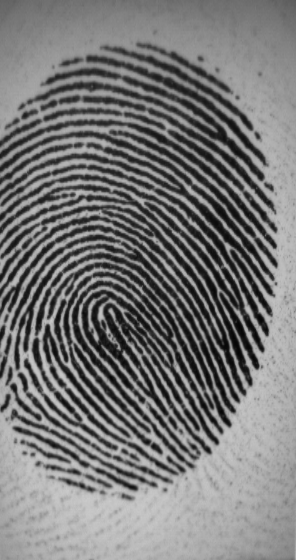

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Read the image using OpenCV
  img = cv2.imdecode(np.frombuffer(uploaded[fn], np.uint8), cv2.IMREAD_UNCHANGED)

  # Now you can work with the image, e.g., display it
  if img is not None:
      cv2_imshow(img) #If you are using colab
  else:
      print("Error: Could not read the image.")

# Run segmentation algorythms

## Variance based segmentation

In [ ]:
def update_variance_image(n = 20, variance_threshold = 200):
  high_variance_image = perform_variance_segmentation(img, n, variance_threshold)
  cv2_imshow(high_variance_image)


n_slider = widgets.IntSlider(value=20, min=1, max=100, step=1, description='n:')
variance_threshold_slider = widgets.IntSlider(value=200, min=1, max=3000, step=10, description='Variance Threshold:')
widgets.interactive(update_variance_image, n=n_slider, variance_threshold=variance_threshold_slider)

interactive(children=(IntSlider(value=20, description='n:', min=1), IntSlider(value=200, description='Variance…

## K-means based segmentation

K-means este o tehnică de segmentare a imaginilor care grupează pixelii într-un anumit număr de clustere (K) pe baza caracteristicilor lor, de obicei culoarea sau intensitatea. Algoritmul începe prin alegerea aleatorie a centroidelor (centrul fiecărui cluster) și apoi atribuie fiecare pixel celui mai apropiat centroid. După atribuire, centroidul fiecărui cluster este recalculat ca medie a pixelilor din acel cluster. Aceste etape de atribuire și recalculare a centroidului se repetă până când nu mai sunt modificări semnificative, iar imaginea este segmentată în K regiuni distincte. K-means este eficient și ușor de implementat, dar necesită ca utilizatorul să specifice numărul de clustere dorit (K).

In [ ]:
def update_vkmeans_image(k = 3):
  k_means_image = perform_kmeans_segmentation(img, k)
  cv2_imshow(k_means_image)


k_slider = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Numarul de clustere:')
widgets.interactive(update_vkmeans_image, k=k_slider)

interactive(children=(IntSlider(value=3, description='Numarul de clustere:', max=10, min=1), Output()), _dom_c…

## Mean shift segmentation

Segmentarea prin Mean Shift este o tehnică neparametrică de segmentare a imaginilor care împarte imaginea în regiuni pe baza distribuției intensităților de culoare sau a altor caracteristici ale pixelilor. Algoritmul funcționează prin pe baza unei ferestre mobile care calculeaza media intensităților din vecinătatea fiecărui pixel, până când se atinge un punct de convergență, adică atunci când media nu se mai schimbă semnificativ. Acest proces se repetă pentru toți pixelii imaginii, iar la final, pixelii care se află în apropierea aceleași medii sunt grupati într-un cluster. Mean Shift este capabil să detecteze regiuni de formă neregulată și nu necesită un număr prestabilit de clustere, spre deosebire de alte metode de segmentare precum K-means.

In [ ]:
def update_mean_shift_image(spatial_radius=10, color_radius=20):
  mean_shift_image = perform_mean_shift_segmentation(img, spatial_radius=spatial_radius, color_radius=color_radius)
  cv2_imshow(mean_shift_image)


sr_slider = widgets.IntSlider(value=10, min=5, max=50, step=1, description='Spatial radius:')
cr_slider = widgets.IntSlider(value=20, min=10, max=50, step=1, description='Color radius:')
widgets.interactive(update_mean_shift_image, spatial_radius=sr_slider, color_radius=cr_slider)

interactive(children=(IntSlider(value=10, description='Spatial radius:', max=50, min=5), IntSlider(value=20, d…

## OTSU Segmentation

Segmentarea Otsu este o metodă automată de binarizare a imaginilor, care determină pragul optim pentru separarea obiectelor de fundal. Aceasta analizează histograma imaginii și calculează un prag care minimizează varianța ponderată între clasele de pixel (obiect și fundal), astfel încât să se obțină o diferențiere cât mai clară între acestea. Algoritmul Otsu este util în special pentru imagini cu contrast slab sau neuniform.

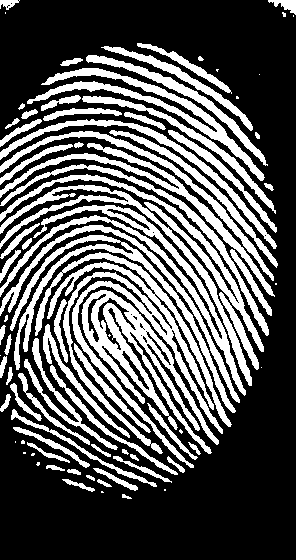

In [ ]:
otsu_image = otsu_segmentation(img)
cv2_imshow(otsu_image)

## MeanShift + variance




In [ ]:
def update_variance_image(n = 20, variance_threshold = 200, spatial_radius=10, color_radius=20):
  high_variance_image = perform_variance_segmentation(img, n, variance_threshold)
  mean_shift_image = perform_mean_shift_segmentation(high_variance_image, spatial_radius=spatial_radius, color_radius=color_radius)
  mean_pixel_value = np.mean(mean_shift_image)
  std_pixel_value = np.std(mean_shift_image)

    # Avoid division by zero
  if std_pixel_value == 0:
     print("Standard deviation is zero. Returning the original image.")

    # Normalize the image
  normalized_image = (mean_shift_image - mean_pixel_value) / std_pixel_value

    # Scale back to 0-255 range for visualization
  normalized_image = cv2.normalize(normalized_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  if len(normalized_image.shape) == 3:  # This means the image is color (BGR)
    gray_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2GRAY)
  else:
    gray_image = normalized_image  # The image is already grayscale
  _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  cv2_imshow(binary_image)


n_slider = widgets.IntSlider(value=20, min=1, max=100, step=1, description='n:')
variance_threshold_slider = widgets.IntSlider(value=200, min=1, max=3000, step=10, description='Variance Threshold:')
sr_slider = widgets.IntSlider(value=10, min=5, max=50, step=1, description='Spatial radius:')
cr_slider = widgets.IntSlider(value=20, min=10, max=50, step=1, description='Color radius:')

widgets.interactive(update_variance_image, n=n_slider, variance_threshold=variance_threshold_slider, spatial_radius=sr_slider, color_radius=cr_slider)

interactive(children=(IntSlider(value=20, description='n:', min=1), IntSlider(value=200, description='Variance…